# Investigating Hybrid Strategies for Systematic Literature Review
**Experiment 3**

This notebook displays:

1. Citation Matrix;
2. Matrix of Indication of Steps to find the selected articles;
3. Graph of Indication of Steps to find the selected articles;
4. Backward and Forward Matrix.

Note: Citation Graph --> CitationGraph.ipynb

In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years, find_citation
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
from collections import OrderedDict
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

custom_strategies.LIMIT_YEAR = 2016
reload()
# !pip install matplotlib-venn

In [2]:
selected = [(varname, w) for varname, w in load_work_map_all_years() if w.category == "snowball"]
names = [varname for varname, w in selected]
#names

In [3]:

order = OrderedDict([
 ('liao2005a', 0),
('liao2005b', 1),
('soydan2006a', 2),
('lee2008a', 3),
('rungratri2008a', 4),
('ryu2008a', 5),
('gazel2009a', 6),
('lee2009a', 7),
('stolfa2010a', 8),
('gazel2012a', 9),
('grambow2012a', 10),
('soydan2012a', 11),
('grambow2013a', 12),
('kabaale2016a', 13),
])
id_to_varname = OrderedDict(sorted([
  (index, varname) for varname, index in order.items()
]))
selected = [(varname, work_by_varname(varname)) for index, varname in id_to_varname.items()]
names = ['{} S{}'.format(w.year, order[varname] + 1) for varname, w in selected]


lista = [(w.name, w.authors, w.year, varname, 'S{}'.format(order[varname] + 1), names) for varname, w in selected]
df = pd.DataFrame (lista)
df

#df = df[[ 0, 1, 2, 3, 4]]
#df.columns = ['Title', 'Authors', 'Year', 'Metakey', 'Study']
#df1 = df.sort_values(by = ['Year', 'Study'], ascending=True)

df = df[[ 0, 1, 2, 3, 4]]
df.columns = ['Title', 'Authors', 'Year', 'Metakey', 'Study']
df["study2"] = df["Study"].apply(lambda x: int(x[1:]))
df1 = df.sort_values(by = ['Year', 'study2'], ascending=True)
del df1['study2']
del df['study2']

#df1 = df.groupby('Year').apply(lambda x: x.sort_values(by = ['Year', 'Study'], ascending = True))

df1

df1_style = df1.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector="th", props=[("text-align", "left")]),
])
print ('\n \033[1m Selected Studies \033[0m')
df1_style.hidden_index = True
df1_style

#from snowballing.dbmanager import insert, set_attribute
#for key, value in order.items():
#    set_attribute(key, "selected_order", "{}".format(value + 1))


  Selected Studies 


Title,Authors,Year,Metakey,Study
A software process ontology and its application,"Liao, Li and Qu, Yuzhong and Leung, H",2005,liao2005a,S1
An ontology-based approach to express software processes,"Liao, Li and Qu, Yuzhong and Leung, H",2005,liao2005b,S2
An OWL ontology for representing the CMMI-SW model,"Soydan, Gokhan Halit and Kokar, M",2006,soydan2006a,S3
Ontology-based intelligent decision support agent for CMMI project monitoring and control,"Lee, Chang-Shing and Wang, Mei-Hui and Chen, Jui-Jen",2008,lee2008a,S4
Project assets ontology (PAO) to support gap analysis for organization process improvement based on CMMI v. 1.2,"Rungratri, Suwanit and Usanavasin, Sasiporn",2008,rungratri2008a,S5
A strategic test process improvement approach using an ontological description for MND-TMM,"Ryu, Hoyeon and Ryu, Dong-Kuk and Baik, Jongmoon",2008,ryu2008a,S6
A CMMI Ontology for An Ontology-Based Software Process Assessment Tool,"Gazel, Sema and Tarhan, Ayca and Sezer, Ebru",2009,gazel2009a,S7
Ontology-based computational intelligent multi-agent and its application to CMMI assessment,"Lee, Chang-Shing and Wang, Mei-Hui",2009,lee2009a,S8
Building process definition with ontology background,"Stolfa, Svatopluk and KoZusznik, Jan and Kosinár, Michal and Duzí, Marie and Cíhalová, Martina and Vondrák, Ivo",2010,stolfa2010a,S9
An ontology based infrastructure to support CMMI-based software process assessment,"Gazel, Sema and Sezer, Ebru Akcpinar and Tarhan, Ayca",2012,gazel2012a,S10


# Citation Matrix

1. The line identifies the article references were found via backward.
2. The column identifies who cited it via forward.
3. The "-" indicates that it is not possible for the article in the row to have references (cite) the article in the column, due to the year of publication.
4. The empty cell indicates that the id row/colum could have refer/cited the paper.

*For example, it can be seen how ID Row (2006 S3) refer to (2005 S1) colum of row 3, and how ID Colum (2006 S3) is cited by (2008 S5), (2008 S6), (2009 S7), (2012 S10), (2012 S11), (2012 S12), (2013 S13) lines of colum 3.*

In [4]:
matrix1 = [
    [varname] + ['-' if cited.year > citer.year else 
     'x' if find_citation(citer, cited) else ''
     for _, cited in selected]
     for varname, citer in selected
]
df = pd.DataFrame(matrix1)
df.set_axis(names, axis=0, inplace=True)
df.set_axis(["id"] + names, axis=1, inplace=True)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v == 'x' else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

cited,id,2005 S1,2005 S2,2006 S3,2008 S4,2008 S5,2008 S6,2009 S7,2009 S8,2010 S9,2012 S10,2012 S11,2012 S12,2013 S13,2016 S14
ref,,,,,,,,,,,,,,,
2005 S1,liao2005a,,,-,-,-,-,-,-,-,-,-,-,-,-
2005 S2,liao2005b,,,-,-,-,-,-,-,-,-,-,-,-,-
2006 S3,soydan2006a,x,,,-,-,-,-,-,-,-,-,-,-,-
2008 S4,lee2008a,,,,,,,-,-,-,-,-,-,-,-
2008 S5,rungratri2008a,,,x,x,,,-,-,-,-,-,-,-,-
2008 S6,ryu2008a,x,,x,,,,-,-,-,-,-,-,-,-
2009 S7,gazel2009a,x,,x,x,,,,x,-,-,-,-,-,-
2009 S8,lee2009a,,,,,,,,,-,-,-,-,-,-
2010 S9,stolfa2010a,,,,,,,,,,-,-,-,-,-


In [5]:
with open("output/table.html", "wb") as html:
    html.write(df_style.render().encode("utf-8"))

In [6]:
# [row[0]]
nmatrix = [[(1 if x == 'x' else float('inf')) for x in row[1:]]
 for row in matrix1]
for i, row in enumerate(nmatrix):
    for j, v in enumerate(row):
        if v == 1:
            nmatrix[j][i] = 1
        if i == j:
            nmatrix[i][j] = 0
pmax = 1
size = len(matrix1)
for k in range(size):
    for i in range(size):
        for j in range(size):
            if nmatrix[i][j] > nmatrix[i][k] + nmatrix[k][j]:
                nmatrix[i][j] = nmatrix[j][i] = nmatrix[i][k] + nmatrix[k][j]
                pmax = max(pmax, nmatrix[i][j])

pmax

3

# Matrix - Steps to Find Selected Article

Number of steps to find an article from the list of selected, through the articles found in the references and by whom cites it.

Subtitle: inf = infinite steps

In [7]:
matrix3 = [
    [s[0]] + row
     for s, row in zip(selected, nmatrix)
]
df = pd.DataFrame(matrix3)
#df.set_index(names)
df.set_axis(names, axis=0, inplace=True)
df.set_axis(["id"] + names, axis=1, inplace=True)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v != float('inf') and isinstance(v, float) else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

cited,id,2005 S1,2005 S2,2006 S3,2008 S4,2008 S5,2008 S6,2009 S7,2009 S8,2010 S9,2012 S10,2012 S11,2012 S12,2013 S13,2016 S14
ref,,,,,,,,,,,,,,,
2005 S1,liao2005a,0,inf,1,2,2,1,1,2,inf,1,1,1,1,inf
2005 S2,liao2005b,inf,0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2006 S3,soydan2006a,1,inf,0,2,1,1,1,2,inf,1,1,1,1,inf
2008 S4,lee2008a,2,inf,2,0,1,3,1,2,inf,1,3,1,3,inf
2008 S5,rungratri2008a,2,inf,1,1,0,2,2,2,inf,1,2,1,2,inf
2008 S6,ryu2008a,1,inf,1,3,2,0,2,3,inf,2,2,2,2,inf
2009 S7,gazel2009a,1,inf,1,1,2,2,0,1,inf,1,2,2,2,inf
2009 S8,lee2009a,2,inf,2,2,2,3,1,0,inf,1,3,1,3,inf
2010 S9,stolfa2010a,inf,inf,inf,inf,inf,inf,inf,inf,0,inf,inf,inf,inf,inf


# Graph Citation - Steps to Find Selected Article

Floyd-Warshall algorithm was used to generate the graph: determines the distance between all the pairs of vertices of a graph and identify steps to find selected articles. 

Subtitle: Node green color = is final selected; Node lightgreen color = not is final selected; Node with (*) = is seed set.

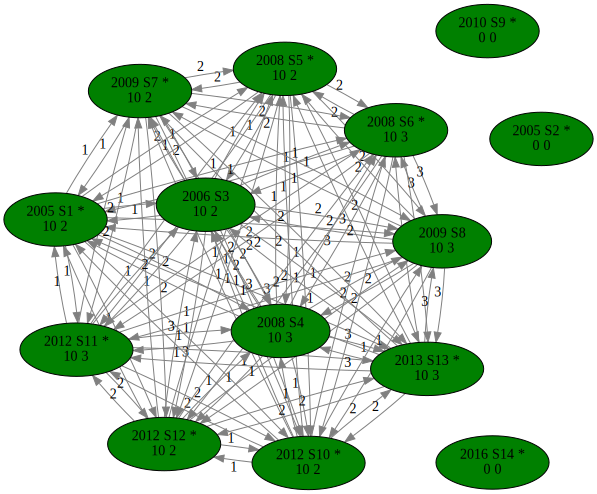

In [8]:
from subprocess import Popen, PIPE as P
class ViewMatrix:
    def __init__(self, nmatrix, names):
        self.nmatrix = nmatrix
        self.names = names
        
    @property
    def dot(self):
        text = ["digraph G {", "graph [ overlap=false ]"]
        for i, name in enumerate(self.names):
            filtered = [x for j, x in enumerate(self.nmatrix[i]) if x != float('inf') if j != i]
            total = sum(1 for x in filtered)
            maxsteps = max(filtered) if filtered else 0
            work = work_by_varname(id_to_varname[int(self.names[i].split()[-1][1:]) - 1])
            color = "green" if getattr(work, 'final_selected', 0) else "LightGreen"
            #nameseed = name + "*"
            #name = nameseed if getattr(work, 'seed_set', 0) else name
            nameseed = "*" if getattr(work, 'seed_set', 0) else " "
            #color = "green" if {x for _, x in load_work_map_all_years() if x.category == "snowball"} else "white"
            text.append(f'"{name}" [fillcolor="{color}", style= "filled", label="{name} {nameseed}\n{total} {maxsteps}"];') 
            
        for i, lis in enumerate(self.nmatrix):
            for j, v in enumerate(lis):
                if v != float('inf') and j != i:
                    text.append('"{}" -> "{}" [label="{}" color="gray"]'.format(self.names[i], self.names[j], v))
        text.append("}")
        return '\n'.join(text)

    def _ipython_display_(self):
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['neato', '-T', "svg", "-Goutputorder=edgesfirst"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/svg+xml'] = image.decode("utf-8")
        except OSError as e:
            print(e)
            if e.errno != os.errno.ENOENT:
                raise

        display(bundle, raw=True)
m = ViewMatrix(nmatrix, names)
m

# Backward and Forward - Details

1. Number of articles visited and how many steps was used to find the article from the list of selected; 
2. Number of articles found via backward and how many were selected;
3. Number of articles found via forward and how many were selected.

In [9]:
strategy = Strategy({})
matrix2 = [[
    "S", "varname", "visits", "steps",
    "total backward", "selected backward",
    "total forward", "selected forward",
    "backward list", "selected backward list",
    "forward list", "selected forward list"
] + ["Step {}".format(i + 1) for i in range(pmax)]]
for varname, index in order.items():
    work = work_by_varname(varname)
    backward = strategy.ref[work]
    selected_backward = [x for x in backward if x.category == "snowball"]
    forward = strategy.rev_ref[work]
    selected_forward = [x for x in forward if x.category == "snowball"]
    steps = [[] for x in range(pmax)]
    for i, v in enumerate(nmatrix[index]):
        if v != float('inf') and v != 0:
            steps[v - 1].append(id_to_varname[i])
    steps = [", ".join(s) for s in steps]
    filtered = [x for j, x in enumerate(nmatrix[index]) if x != float('inf') if j != i]
    total = sum(1 for x in filtered)
    maxsteps = max(filtered) if filtered else 0
    row = [
        "S{}".format(index + 1), varname,
        total, maxsteps,
        len(backward), len(selected_backward),
        len(forward), len(selected_forward),
        ", ".join(x.metakey for x in backward),
        ", ".join(x.metakey for x in selected_backward),
        ", ".join(x.metakey for x in forward),
        ", ".join(x.metakey for x in selected_forward),
    ] + steps
    
    matrix2.append(row)
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_colwidth',1000)
df3 = pd.DataFrame(matrix2)


df4 = df3[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]  
df4.columns = ['Study','Metakey', 'Visited', 'Steps','Total Backward', 'Selected Backward', 'Total Forward', 'Selected Forward','Backward List', 'Selected Backward List','Forward List', 'Selected Forward List' ]

df4 = df4.drop(df4.index[[0]])

df4_style = df4.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df4_style.hidden_index = True
df4_style

Study,Metakey,Visited,Steps,Total Backward,Selected Backward,Total Forward,Selected Forward,Backward List,Selected Backward List,Forward List,Selected Forward List
S1,liao2005a,11,2,15,0,64,7,"paulk1993a, isoiec1998a, haase1994a, wang2000a, cmusei2002a, conradi2002a, lopez2001a, conradi1994a, ben1993a, bandinelli1993a, deng2003a, alonso1995a, liao2004a, chandrasekaran1999a, patel2004a",,"gazel2009a, grambow2012a, grambow2013a, zhao2009a, pardo2012a, bringuente2011a, colomo2008a, grambow2011d, al2011a, caffery2012a, jeners2013a, ryu2008a, grambow2011e, gazel2012a, fitsilis2014a, kayed2010a, soydan2012a, sarantis2010a, teuteberg2009a, pricope2011a, jeners2012a, teuteberg2013a, pardo2014a, fadila2009a, bibi2014a, martoglia2011a, jeners2012b, jeners2013b, mora2010a, hamri2015a, aoussat2012b, jeners2012c, demirsoy2013a, mora2013a, tarhan2017a, colomo2008b, pardo2014ab, souza2012a, pyshkin2015a, kluth2013a, ahmad2009a, colomo2008ab, roongsangjan2017a, lourinho2017a, balaji2012a, nielsen2008a, zemaitytė2016a, liu2007ab, chansylilath2014a, ngwenya2016a, nizar2010a, ciancarini2018a, aoussat2014a, noroozi2012a, butka2015a, shanthini2013a, moraa2010a, fitsilis2015a, cadavid2018a, lang2014a, ontolojilerin2011a, aoussat2012a, aau2009a, soydan2006a","gazel2009a, grambow2012a, grambow2013a, ryu2008a, gazel2012a, soydan2012a, soydan2006a"
S2,liao2005b,1,0,11,0,1,0,"conradi2002a, lopez2001a, wang2000b, berners2001a, w3c2004a, (0, ), (0, ), w32001a, w32001b, miller2003a, liao2004b",,tarhan2017a,
S3,soydan2006a,11,2,6,1,52,14,"cmmi2002ab, w3c2004c, carnegie2005a, carnegie2006a, mendes2004a, liao2005a",liao2005a,"gazel2009a, gazel2012a, grambow2012a, grambow2013a, rungratri2008a, ryu2008a, pardo2012a, colomo2008a, grambow2011d, ryu2008a, grambow2011e, sharifloo2008b, gazel2012a, fitsilis2014a, rilling2008a, rilling2008b, schugerl2009a, hyland2008a, soydan2012a, rungratri2008a, mejia2016a, grambow2013a, grambow2012a, martoglia2011a, bergamaschi2015a, hmood2010a, mora2010a, pardo2015a, hamri2015a, ying2009a, gazel2009a, mora2013a, yoshidome2014a, proen2016a, baldassarre2016a, tarhan2017a, hyland2008b, colomo2008b, yoshidome2014b, shia2015a, albuquerque2017a, colomo2014a, ciancarini2018a, nielsen2008a, proen2018a, moraa2010a, fitsilis2015a, cadavid2018a, rilling2008c, peld2015a, aoussat2012a, soydan2012a","gazel2009a, gazel2012a, grambow2012a, grambow2013a, rungratri2008a, ryu2008a, ryu2008a, gazel2012a, soydan2012a, rungratri2008a, grambow2013a, grambow2012a, gazel2009a, soydan2012a"
S4,lee2008a,11,3,15,0,107,4,"gandon2006a, vetere1999a, musen1995a, huang2005a, pan2004a, hsieh2006a, hamdi2006a, pratt2006a, li2006a, cmmi2005a, wu2006a, han2006a, russo2006a, yager1988a, yager1993a",,"gazel2009a, gazel2012a, bobillo2011a, lee2011a, lee2009d, isern2011a, balaji2010a, lee2010a, chen2011b, milea2012a, bajo2009a, abanda2013a, kazemifard2011a, acampora2011a, acampora2010a, kang2012a, plaza2009a, zhou2015a, lee2008d, acampora2011b, kalpana2011a, gonzalez2011a, cheng2011a, nasir2008a, wang2008b, lee2012a, alfaraj2011a, lee2009e, fitsilis2014a, garrido2010a, crespo2012a, shoaib2010a, yang2010a, grzybek2014a, lee2010b, lee2010c, rungratri2008a, lee2008c, hoock2010a, lee2007ab, wang2012b, wang2010a, lee2008e, milea2013a, nojima2011a, chen2011c, plaza2016a, wang2011a, chang2009a, andrade2008b, lee2011b, wang2008c, xu2013a, xu2015a, haghighi2012a, guo2010a, lagos2017a, cheng2009b, kuo2011a, heinzle2017a, wang2013a, mora2013a, liu2007a, lee2007d, tarhan2017a, xua2014a, cristani2010a, cristani2008a, wang2013b, freitas2017a, amid2013a, japan2009a, japan2010a, quevedo2015a, japan2016a, hou2015a, laroque2012a, erdem2010a, dias2013a, poulos2017a, ramadhan2013a, lee2013b, su2011a, xu2015b, wang2011ab, jia2012a, ratnaraj2001a, nielsen2008a, garcía2017a, proen2018a, ding2017a, wang2012c, wang2010b, li2014a, lee2013c, chen2007a, bilgehan2010a, fitsilis2015a, lang2017a, garcía2015ab, japan2012a, crespo2011a, shia2015a, computa2017a, lee2013d, japan2007a, soydan2012a","gazel

In [10]:
df.to_excel("tabela_grafo.xlsx")

In [11]:
#nmatrix[13]